In [1]:
%matplotlib inline
import tweepy
import ConfigParser
import csv
import time
import pandas
import re
from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen
import collections
from collections import Counter
from collections import defaultdict
import nltk
from nltk.stem import *
from nltk.corpus import sentiwordnet as swn
from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen
from collections import defaultdict
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
import json
from pprint import pprint
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tarfile

In [2]:
def getTwitter(config_file):
    """ 
    Function Name :get_twitter
    Function      :Read the config_file and construct an instance of TweepyAPI.
    Args          :config_file - A config file in ConfigParser format with Twitter credentials.
    Returns       :An instance of TweepyAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)
    OAUTH_KEYS = {'consumer_key':config.get('twitter', 'consumer_key'),
                  'consumer_secret':config.get('twitter', 'consumer_secret')}
    
    auth = tweepy.OAuthHandler(OAUTH_KEYS['consumer_key'], OAUTH_KEYS['consumer_secret'])
    api = tweepy.API(auth)             
    return api

twitter = getTwitter('twitter.cfg')
print('Established Twitter connection.')

Established Twitter connection.


In [3]:
def readRestaurants(fileName):
    """ 
    Function Name :read_restaurants
    Function      :Read a filename and extracts the restaurant names form it.
    Args          :fileName - A csv file with the list of restaurant in Chicago.
    Returns       :A list of restaurants.
    """
    fields = ['DBA Name', 'Facility Type']
    data = pandas.read_csv(fileName, skipinitialspace=True, usecols=fields)
    Restaurants = (data.loc[data['Facility Type'] == 'Restaurant'])
    listRest = Restaurants['DBA Name'].values.tolist()
    tempRestaurant=[]
    restaurants = []
    for index in listRest:
        temp = ''.join(index.partition("#")[0:1])
        temp2 = ''.join(temp.partition("'")[0:1])
        tempRestaurant.append(temp2)

    for rest in tempRestaurant:
        if rest not in restaurants:
            restaurants.append(rest)          
    return restaurants

restaurants = readRestaurants("Food_Inspections.csv")
print ("Total number of Restaurants from Chicago Data Portal: %d" %len(restaurants))

print "First 10 Restaurants from the list are: "
print restaurants[:10]

Total number of Restaurants from Chicago Data Portal: 8798
First 10 Restaurants from the list are: 
['CEMITAS PUEBLA', 'DUNKIN DONUTS/BASKIN ROBBINS', 'NESH MEDITERRANEAN GRILL', 'LOS MIXIOTES', 'THE GAME', 'LA REYNA DEL SAZON', 'GILBERT WOODS', 'RED SNAPPER', 'OPART THAI', 'BALZEKAS MUSEUM OF LITHUANIAN']


In [4]:
def getTweets(twitter, Search_Query):
    """ 
    Function Name :getTweets
    Function      :Queries twitter using the Tweepy api with a search query and returns the results.
    Args          :twitter - A Tweepy API and Search_Query - The string to be queried.
    Returns       :All tweets returned by the query.
    """
    Tweets = tweepy.Cursor(twitter.search, q=Search_Query, lang="en").items(5000)
    return Tweets

In [5]:
def getTweetList(twitter, Search_Query):    
    """ 
    Function Name :getTweetList
    Function      :Queries twitter using the Tweepy api with a search query and returns the results.
    Args          :twitter - A Tweepy API and Search_Query - The string to be queried.
    Returns       :All tweets returned by the query.
    """    
    Tweets = getTweets(twitter, Search_Query)
    
    count = 0
    
    tweetList=[]
    
    for tweet in Tweets:
        count+=1
        tweetList.append(tweet.text.encode('utf-8'))

    return tweetList

CEMITAS_List = getTweetList(twitter, "CEMITAS PUEBLA")
print len(CEMITAS_List)

20


In [6]:
print 'read %d giordanos tweets' % len(getTweetList(twitter, "giordanos"))

read 432 giordanos tweets


In [7]:
print 'First 5 tweets are:'
print getTweetList(twitter, "giordanos")[:5]

First 5 tweets are:
["If I didn't have to work tomorrow, I'd be on the next flight out to Chicago! #pizza #giordanos \xf0\x9f\x8d\x95\xe2\x9c\x88\xef\xb8\x8f https://t.co/dkFAuPN3jt", "@UnoOtter giordanos?! We're there now!", 'What a wonderful gift idea from 700 miles away; love that #Giordanos https://t.co/YA0G7jbCjz', 'Leftover Giordanos at the crib \xf0\x9f\x99\x8c\xf0\x9f\x8f\xbe', 'Someone buy me a giordanos deep dish cheese pizza please please please \xf0\x9f\x92\x97\xf0\x9f\x92\x97\xf0\x9f\x92\x97']


In [8]:
def tokenize_with_not(text):
    """ 
    Function Name :tokenize_with_not
    Function      :Whenever the term 'not'appears, changes the two subsequent tokens to have the prefix 'not_'.
    Args          :text - A text string to be tokenized.
    Returns       :A list of tokens.
    """
    keyWord = "not_"
    listTokens = re.sub('\W+', ' ', text.lower()).split()
    for index in range(len(listTokens)-1):
        if listTokens[index] == "not":
            listTokens[index+1]=keyWord+listTokens[index+1]
            if ((index+1)!=(len(listTokens)-1)):
                listTokens[index+2]=keyWord+listTokens[index+2]
    return listTokens

In [9]:
""" 
Downloads the AFINN package and forms a dictionary with all the terms in the list and their respective scores.
"""
url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(StringIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0]] = int(parts[1])

print 'read', len(afinn), 'AFINN terms.\nE.g.:', afinn.items()[:10]

read 2462 AFINN terms.
E.g.: [('limited', -1), ('suicidal', -2), ('pardon', 2), ('desirable', 2), ('protest', -2), ('lurking', -1), ('controversial', -2), ('hating', -3), ('ridiculous', -3), ('hate', -3)]


In [10]:
""" 
Function Name :afinnSentiment
Function      :Calculates the AFINN score based on the tokens passed to it and returns 
               the positive and negative scores.
Args          :terms - A set of tokens, afinn - The AFINN dictionary.
Returns       :Positive and Negative scores.
"""
def afinnSentiment(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print '\t%s=%d' % (t, afinn[t])
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a hokey plot that is both to good and bad".split()
print 'AFINN:\n', afinnSentiment(doc, afinn, verbose=True)

AFINN:
	good=3
	bad=-3
(3, 3)


In [11]:
tweetList = getTweetList(twitter, "giordanos")
print len(tweetList)

432


In [12]:
tokenslist = [tokenize_with_not(t) for t in tweetList]
print tokenslist[:5]

[['if', 'i', 'didn', 't', 'have', 'to', 'work', 'tomorrow', 'i', 'd', 'be', 'on', 'the', 'next', 'flight', 'out', 'to', 'chicago', 'pizza', 'giordanos', 'https', 't', 'co', 'dkfaupn3jt'], ['unootter', 'giordanos', 'we', 're', 'there', 'now'], ['what', 'a', 'wonderful', 'gift', 'idea', 'from', '700', 'miles', 'away', 'love', 'that', 'giordanos', 'https', 't', 'co', 'ya0g7jbcjz'], ['leftover', 'giordanos', 'at', 'the', 'crib'], ['someone', 'buy', 'me', 'a', 'giordanos', 'deep', 'dish', 'cheese', 'pizza', 'please', 'please', 'please']]


In [13]:
positives = []
negatives = []
for tweet in tokenslist:
    pos, neg = afinnSentiment(tweet, afinn)
    if pos > neg:
        positives.append((' '.join(tweet), pos, neg))
    elif neg > pos:
        negatives.append((' '.join(tweet), pos, neg))

In [14]:
# Print top positives:
for tweet, pos, neg in sorted(positives, key=lambda x: x[1], reverse=True)[:10]:
    print pos, neg, tweet

10 0 jeffcannata happy turkey day enjoy my hometown of chicago giordanos forever thanks for your continual enthusiastic contributions
9 0 what a wonderful gift idea from 700 miles away love that giordanos https t co ya0g7jbcjz
8 0 ovidioluisxo ny pizza is always king but its good to try it if you never had it giordanos is pretty amazing
7 0 trying to decide between this amazing dressing i made and ordering a stuffed pizza from giordanos decisions lol innerfatgirl
7 0 farbodnba mclaughlin_bo yea i think lou s is the best and then there s giordanos which is pretty good but it s sponsored by d rose
6 0 3 million networth and 1 million in liquid for me to bring giordanos to la lol im on a mission dammit lol
6 0 annebadasci squandered my chance but giordanos is amazing
5 0 vintagedaggers i think its good i would have like some giordanos though
5 0 kiss my a that s good pizza giordanos https t co ekkxkaffxm
4 3 rt nytimesbooks a short and elegant new novel details how a small family unravels

In [15]:
# Print top negatives:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True)[:10]:
    print pos, neg, tweet

0 6 mff goals 1 alcohol 2 take questionable regretful and shameful selfies 3 animals 4 giordanos 5 mariano s orange juice
0 6 never again makhari act a damn fool at giordanos
4 5 i want some giordanos before i leave man it s a must shit was too good
3 4 shit would pop off rt gorobotic 3 million networth and 1 million in liquid for me to bring giordanos to la lol im on a mission dammit
0 4 k_rich mike_malone1 kyle i will personally come to giordanos right now to beat your ass
0 4 damn only if giordanos had this https t co 0qilgyucrx
0 4 another way to get me to cancel a first date choose we go to dave and busters finally something worse than the bar at giordanos truestory
0 4 giordanos dat pizza wasn t shit
3 4 rt mandrewxxx i fucking love giordanos https t co ffnptaywl8
3 4 i fucking love giordanos https t co ffnptaywl8


In [16]:
# Which words contribute most to sentiment?
all_counts = Counter()
for tweet in tokenslist:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(), key=lambda x:x[1], reverse=True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print '%s count=%d sentiment=%d' % (token, count, afinn[token])
        i += 1
        if i > 10:
            break

like count=171 sentiment=2
novel count=40 sentiment=2
elegant count=39 sentiment=2
ill count=37 sentiment=-2
resigns count=36 sentiment=-1
best count=11 sentiment=3
safe count=8 sentiment=1
lol count=8 sentiment=3
want count=7 sentiment=1
good count=7 sentiment=3
love count=5 sentiment=3


In [17]:
""" 
Function Name :sentiScore
Function      :Queries twitter and gets the tweets based on a restaurant name and calculates the NLTK sentiscore.
Args          :restaurants - The list of restaurants, Twitter - The Tweepy API.
Returns       :The positive and negative sentiscores of each restaurant in a list.
"""
def sentiScore(restaurants, twitter):
    d ={}
    for item in restaurants:
        pscore = 0
        nscore = 0
        tokens = []
        Tweets = getTweets(twitter, item)
        for tweet in Tweets:
            tokens.append(tokenize_with_not(tweet.text))
        for token in tokens:
            tagged=nltk.pos_tag(token)     
            for i in range(0,len(tagged)):
                if 'NN' in tagged[i][1] and len(swn.senti_synsets(tagged[i][0],'n'))>0:
                    pscore=pscore+(list(swn.senti_synsets(tagged[i][0],'n'))[0]).pos_score() 
                    nscore=nscore+(list(swn.senti_synsets(tagged[i][0],'n'))[0]).neg_score() 
                elif 'VB' in tagged[i][1] and len(swn.senti_synsets(tagged[i][0],'v'))>0:
                    pscore=pscore+(list(swn.senti_synsets(tagged[i][0],'v'))[0]).pos_score()
                    nscore=nscore+(list(swn.senti_synsets(tagged[i][0],'v'))[0]).neg_score()
                elif 'JJ' in tagged[i][1] and len(swn.senti_synsets(tagged[i][0],'a'))>0:
                    pscore=pscore+(list(swn.senti_synsets(tagged[i][0],'a'))[0]).pos_score()
                    nscore=nscore+(list(swn.senti_synsets(tagged[i][0],'a'))[0]).neg_score()
                elif 'RB' in tagged[i][1] and len(swn.senti_synsets(tagged[i][0],'r'))>0:
                    pscore=pscore+(list(swn.senti_synsets(tagged[i][0],'r'))[0]).pos_score()
                    nscore=nscore+(list(swn.senti_synsets(tagged[i][0],'r'))[0]).neg_score()
        d[item]=[str(pscore), str(nscore)]
    return d

In [18]:
""" 
Function Name :singleSentiScore
Function      :Queries twitter and gets the tweets based on a restaurant name and calculates the NLTK sentiscore.
Args          :search_query - Restaurant name to be queried, Twitter - The Tweepy API.
Returns       :The positive and negative sentiscores of each restaurant in a list.
"""
def singleSentiScore(twitter, searchQuery):
    d ={}
    pscore = 0
    nscore = 0
    tokens = []
    Tweets = getTweets(twitter, searchQuery)
    for tweet in Tweets:
        tokens.append(tokenize_with_not(tweet.text))     
    for token in tokens:
        tagged=nltk.pos_tag(token)     
        for i in range(0,len(tagged)):
            if 'NN' in tagged[i][1] and len(swn.senti_synsets(tagged[i][0],'n'))>0:
                pscore=pscore+(list(swn.senti_synsets(tagged[i][0],'n'))[0]).pos_score() 
                nscore=nscore+(list(swn.senti_synsets(tagged[i][0],'n'))[0]).neg_score() 
            elif 'VB' in tagged[i][1] and len(swn.senti_synsets(tagged[i][0],'v'))>0:
                pscore=pscore+(list(swn.senti_synsets(tagged[i][0],'v'))[0]).pos_score()
                nscore=nscore+(list(swn.senti_synsets(tagged[i][0],'v'))[0]).neg_score()
            elif 'JJ' in tagged[i][1] and len(swn.senti_synsets(tagged[i][0],'a'))>0:
                pscore=pscore+(list(swn.senti_synsets(tagged[i][0],'a'))[0]).pos_score()
                nscore=nscore+(list(swn.senti_synsets(tagged[i][0],'a'))[0]).neg_score()
            elif 'RB' in tagged[i][1] and len(swn.senti_synsets(tagged[i][0],'r'))>0:
                pscore=pscore+(list(swn.senti_synsets(tagged[i][0],'r'))[0]).pos_score()
                nscore=nscore+(list(swn.senti_synsets(tagged[i][0],'r'))[0]).neg_score()        
    d[searchQuery]=[str(pscore), str(nscore)]
    return d

In [19]:
""" 
Function Name :pieChart
Function      :Plots the pieChart of positive .
Args          :scoreDict - A list of scores of restaurants in a dictionary.
Returns       :The positive and negative sentiscores of each restaurant in a list.
"""
def pieChart(scoreDict):
    for key in scoreDict:
        labels = 'Positive Sentiment Score', 'Negative Sentiment Score'
        sizes = [scoreDict[key][0],scoreDict[key][1]]
        colors = ['yellowgreen', 'gold']
        plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
        plt.axis('equal')
        return key

Enter the name of the Restaurant in Chicago: McDonald
fetching the Scores:
{'McDonald': ['1693.069', '1284.056']}


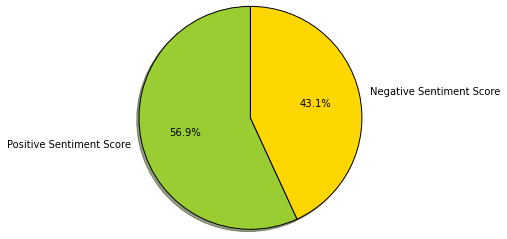

In [20]:
searchQuery = raw_input('Enter the name of the Restaurant in Chicago: ')

if searchQuery in restaurants:
    print 'fetching the Scores:'
    scoreDict=singleSentiScore(twitter,searchQuery)
    print scoreDict
    pieChart(scoreDict)
else:
    print "Please Check the name of the Restaurant"